# Static Mapping: TNIC Data

This notebook provides more details on using `evomap` for deriving static market maps, especially for large input matrices.  

## Sections

1. [Loading the Data](#section_1)

2. [Mapping the Data](#section_2)

3. [Exploring the Map](#section_3)

4. [Evaluating the Map](#section_4)

## References

Parts of this example are based on

<a name = "ref_1"></a>
<a name = "ref_2"></a>
```
[1] Matthe, M., Ringel, D. M., Skiera, B. (2022), Mapping Market Structure Evolution. Forthcoming in Marketing Science. https://doi.org/10.1287/mksc.2022.1385

[2] Hoberg, G & Phillips, G. (2016), "Text-Based Network Industries and Endogenous Product Differentiation.", Journal of Political Economy 124 (5), 1423-1465.
```

**Last updated:** September 2023


Read the **full EvoMap paper** here (open access): <a href = 'https://doi.org/10.1287/mksc.2022.1385'>https://doi.org/10.1287/mksc.2022.1385</a>

**Contact:** For questions or feedback, please <a href = 'mailto:matthe@wiwi.uni-frankfurt.de'>get in touch</a>.

<a id = 'section_1'></a>
## Loading the Data
First, load all required imports for this demonstration and set the seed to ensure reproducibility. 

In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(123) 

For this demonstration, we use a larger sample of the TNIC data also used in [[1]](#ref_1). The original data is provided at ***https://hobergphillips.tuck.dartmouth.edu/***. 

For more background on TNIC data, see [[2]](#ref_2). *If you intend to use these data, make sure to cite these authors' original work!*

In the TNIC data, each row corresponds to a single firm-firm pair at a specific point in time. Thus, each firm variable appears twice in each row (once for each firm). We provide these  data merged with additional firm information as part of this package. 

In [2]:
from evomap.datasets import load_tnic_snapshot
tnic_snapshot = load_tnic_snapshot()
print(tnic_snapshot.keys())

dict_keys(['matrix', 'label', 'cluster', 'size'])


The data consist of four parts: 

- a symmetric similarity **matrix**, containing the pairwise relationships among all firms 
- a **label** array, containing the name for each firm
- **cluster** assignments, based on pre-clustering of the similarity matrix (obtained via a Community Detection algorithm)
- a **size** array, containing each firm's market capitalization (*)

(*) Note, that we cannot provide the original market capitalization for licencing reasons, and therefore report a synthetic derivative which is correlated to the firms' original market capitalization.   

In [3]:
# Load each element of the input data
sim_mat = tnic_snapshot['matrix']
labels = tnic_snapshot['label']
clusters = tnic_snapshot['cluster']
market_caps = tnic_snapshot['size']

In [4]:
display("Total number of firms: {0}, such as ..".format(len(labels)))
for label in labels[:5]:
    display(" .. " + label)

'Total number of firms: 1092, such as ..'

' .. AMERICAN AIRLINES GROUP INC'

' .. AARONS HOLDINGS COMPANY INC'

' .. ABBOTT LABORATORIES'

' .. AETNA INC'

' .. AIR T INC'

For each (firm, firm) pair these data include a measure of (non-negative) pairwise similarity, ranging between 0 and 1:

In [5]:
display("Smallest similarity: {0}".format(np.min(sim_mat)))
display("Highest similarity: {0}".format(np.max(sim_mat)))

'Smallest similarity: 0.0'

'Highest similarity: 0.8652'

<a id = 'section_2'></a>
## Mapping the Data

To project these relationships onto the 2D plane, `evomap` implements a range of popular (static) mapping methods.

Here, we will be using and comparing

- Classic Multidimensional Scaling (CMDS),  
- Sammong Mapping, and
- t-SNE 

and see how they perform on mapping the TNIC data. 

Running these methods follows the typical `scikit-learn` conventions (fit / transform / fit_transform), for instance

```
output = CMDS().fit_transform(D)
```

where `D` is supposed to be a data matrix (here: a matrix of pairwise distances). 

As a result, `evomap` is fully compatible with other methods implemented in the scikit-learn library.
For instance, you could easily integrate <a href = 'https://scikit-learn.org/stable/modules/manifold.html#isomap'>Isomap</a> into the workflow below, and use `evomap` for preprocessing, plotting, or evaluation. Alternatively, you could use the <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html'>scikit-learn implementation of t-SNE</a>, which implements a few additional features (such as the Barnes-Hut approximation). For details, see the <a href = 'https://scikit-learn.org/stable/modules/manifold.html'>sklearn.manifold documentation</a>. Further static mapping methods relying on gradient-based optimization routines can easily be integrated into evomap.

Irrespectively of which method you choose, you might need to transform your data according to the method's specific requirements. Here, we transform the TNIC data (which represent pariwise similarities) into pairwise distances. A straight-forward way to do so is 'mirroring' them. Note that the choice of such transformations will have an impact on the resultant maps. 

In [6]:
from evomap.preprocessing import sim2diss, normalize_diss_mat
D = sim2diss(sim_mat, transformation= 'inverse') 
D = normalize_diss_mat(D)

For a start, we use Sammon Mapping (a non-linear variant of Multidimensional Scaling) to project this matrix onto the two-dimensional plane.

In [7]:
from evomap.mapping import Sammon
method = Sammon(
    input_type = 'distance', n_iter= 500, verbose = 2)
    
Y_sammon = method.fit_transform(D)

[SAMMON] Initialization 1/1
[SAMMON] Running Gradient Descent with Backtracking via Halving
[SAMMON] Iteration 50 -- Cost: 0.49 -- Gradient Norm: 0.1572
[SAMMON] Iteration 100 -- Cost: 0.47 -- Gradient Norm: 0.1080
[SAMMON] Iteration 150 -- Cost: 0.46 -- Gradient Norm: 0.0390
[SAMMON] Iteration 200 -- Cost: 0.46 -- Gradient Norm: 0.0205
[SAMMON] Iteration 250 -- Cost: 0.46 -- Gradient Norm: 0.0097
[SAMMON] Iteration 300 -- Cost: 0.46 -- Gradient Norm: 0.0045
[SAMMON] Iteration 350 -- Cost: 0.46 -- Gradient Norm: 0.0021
[SAMMON] Iteration 400 -- Cost: 0.46 -- Gradient Norm: 0.0011
[SAMMON] Iteration 414: gradient norm vanished. Final cost: 0.46


The output `Y` always consists of an array containing the map coordinates. Y is shaped as (n_samples, n_dims), where 'n_dims' usually equals two.

In [8]:
Y_sammon

array([[ 0.45197858,  0.12856233],
       [-0.51077425,  0.01469074],
       [ 0.08837376,  0.58975072],
       ...,
       [-0.07210468, -0.0930874 ],
       [ 0.16441939,  0.00493722],
       [-0.07203109, -0.09057264]])

<a id = 'section_3'></a>
## Exploring the Map

While one could simply visualize these coordinates in a 2D scatterplot, `evomap` provides a lot of functionality to create 
much richer market maps. All required functions to do so are located within the  `evomap.printer` module. 

The baseline function is `draw_map`:

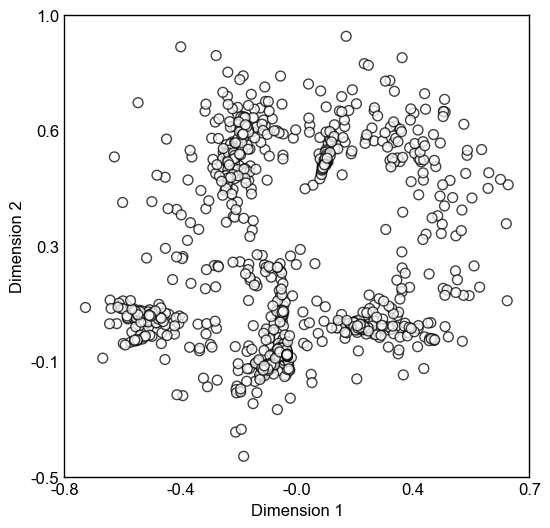

In [9]:
from evomap.printer import draw_map
draw_map(Y_sammon)

You can change the map's aesthetics and bind additional data to it via `draw_map`'s keyword arguments. For instance, if class labels are available (e.g., obtained via clustering or additional metadata), they can be added as colors. Here, we can use SIC codes for coloring:

/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")


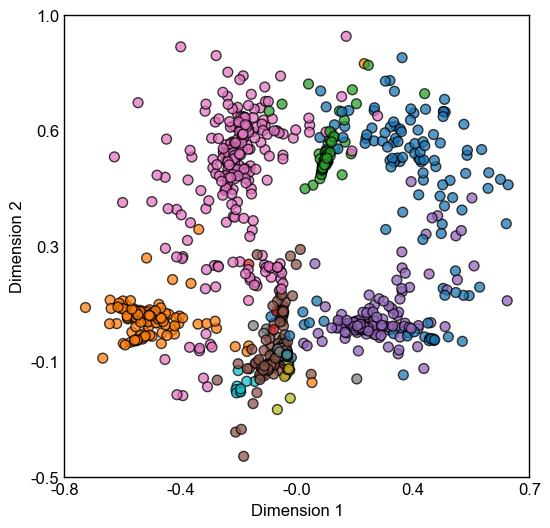

In [10]:
draw_map(Y_sammon, color = clusters)

Likewise, one can use additional data to control each point's size. Here, we are using market capitalization:

/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")


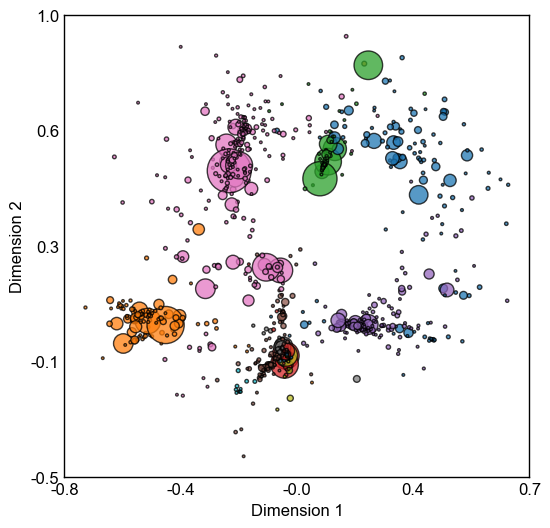

In [11]:
draw_map(Y_sammon, color = clusters, size = market_caps)

One can further annotate the map, using labels (e.g., to identify and highlight the positions of specific firms)

/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")


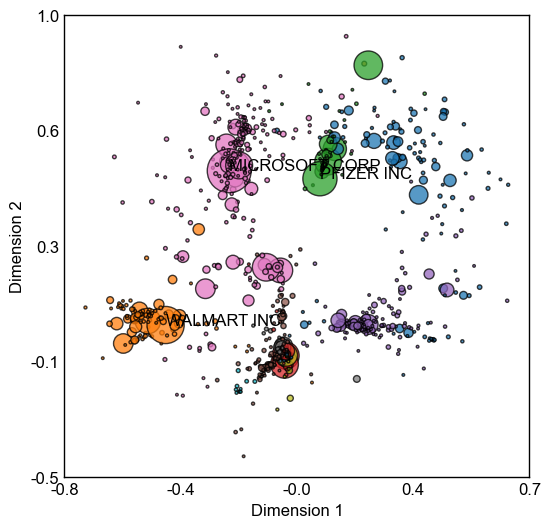

In [12]:
draw_map(
    Y_sammon, 
    color = clusters, 
    label = labels, 
    size = market_caps,
    highlighted_labels= ['MICROSOFT CORP', 'WALMART INC', 'PFIZER INC'])

Note that one can also use additional keyword arguments to adjust the plot and its labels further

/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")


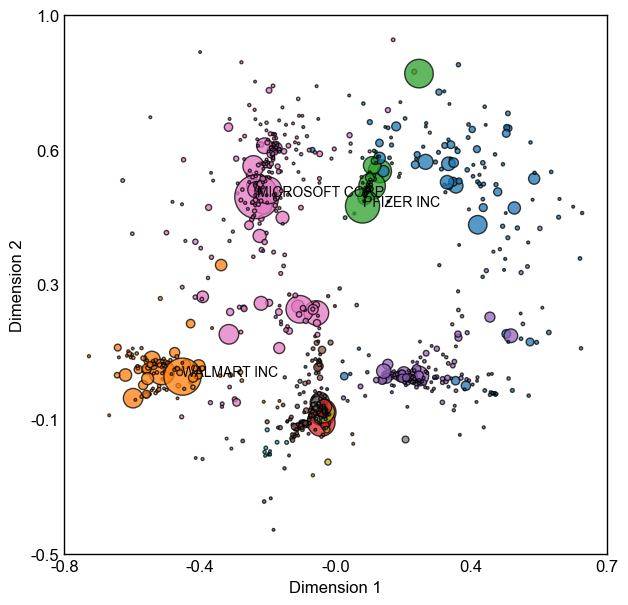

In [13]:
from matplotlib import pyplot as plt
draw_map(
    Y_sammon, 
    color = clusters, 
    size = market_caps,
    label = labels, 
    fig_size=(7,7),
    fontdict= {'family': 'Arial', 'size': 10},
    highlighted_labels= ['MICROSOFT CORP', 'WALMART INC', 'PFIZER INC'])

<a id = 'section_4'></a>
## Evaluating the Map

Finally, one should always carefully check how good the resultant map represents the input data. To do so, multiple `metrics` are available from the corresponding module.

A popular choice, especially for larger markets, is the hitrate of nearest-neighbor recovery.

In [14]:
from evomap.metrics import hitrate_score
hitrate_score(
    D = sim_mat, 
    X = Y_sammon, 
    n_neighbors = 10, 
    input_format = 'similarity')

0.24404761904761904

Let's compare the result to two other methods to generate the map.

Classic Multidimensional Scaling (CMDS):

In [15]:
D_norm = D / np.max(D)

In [16]:
from evomap.mapping import MDS
Y_MDS = MDS(
    input_type = 'distance', 
    verbose = 2, 
    n_iter = 500).fit_transform(D_norm)

[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 50 -- Cost: 0.47 -- Gradient Norm: 0.3298
[MDS] Iteration 100 -- Cost: 0.44 -- Gradient Norm: 0.1952
[MDS] Iteration 150 -- Cost: 0.43 -- Gradient Norm: 0.1265
[MDS] Iteration 200 -- Cost: 0.43 -- Gradient Norm: 0.0935
[MDS] Iteration 250 -- Cost: 0.43 -- Gradient Norm: 0.0737
[MDS] Iteration 300 -- Cost: 0.43 -- Gradient Norm: 0.0696
[MDS] Iteration 350 -- Cost: 0.43 -- Gradient Norm: 0.0461
[MDS] Iteration 400 -- Cost: 0.43 -- Gradient Norm: 0.0191
[MDS] Iteration 450 -- Cost: 0.43 -- Gradient Norm: 0.0233
[MDS] Iteration 500 -- Cost: 0.43 -- Gradient Norm: 0.0266
[MDS] Maximum number of iterations reached. Final cost: 0.43


t-distributed Stochastic Neighbor Embedding (t-SNE):

In [17]:
from evomap.mapping import TSNE
Y_tsne = TSNE(input_type= 'distance', verbose = 2).fit_transform(D)

[TSNE] Calculating P matrix ...
[TSNE] Gradient descent with Momentum: 0.5
[TSNE] Iteration 50 -- Cost: 15.61 -- Gradient Norm: 0.0390
[TSNE] Iteration 100 -- Cost: 15.22 -- Gradient Norm: 0.0236
[TSNE] Iteration 150 -- Cost: 15.07 -- Gradient Norm: 0.0192
[TSNE] Iteration 200 -- Cost: 15.00 -- Gradient Norm: 0.0211
[TSNE] Iteration 250 -- Cost: 14.98 -- Gradient Norm: 0.0184
[TSNE] Maximum number of iterations reached. Final cost: 14.98
[TSNE] Gradient descent with Momentum: 0.8
[TSNE] Iteration 289: gradient norm vanished.


Compare how well they perform:

In [18]:
display("MDS Hitrate: {0:.2f}".format(hitrate_score(D = D, X = Y_MDS, n_neighbors=10, input_format = 'dissimilarity')))
display("Sammon Hitrate: {0:.2f}".format(hitrate_score(D = D, X = Y_sammon, n_neighbors=10, input_format = 'dissimilarity')))
display("t-SNE Hitrate: {0:.2f}".format(hitrate_score(D = D, X = Y_tsne, n_neighbors=10, input_format = 'dissimilarity')))

'MDS Hitrate: 0.24'

'Sammon Hitrate: 0.24'

't-SNE Hitrate: 0.50'

These differences in solution quality also become apparent when looking at the map output:

/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")
/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")
/Users/mpmatthe/anaconda3/envs/evomap-test/lib/python3.12/site-packages/evomap/printer.py:202: UserWarning: Number of color labels exceeds the number of available colors in the colormap; colors will repeat.
  warnings.warn("Number of color labels exceeds the number of available colors in the colormap; colors will repeat.")


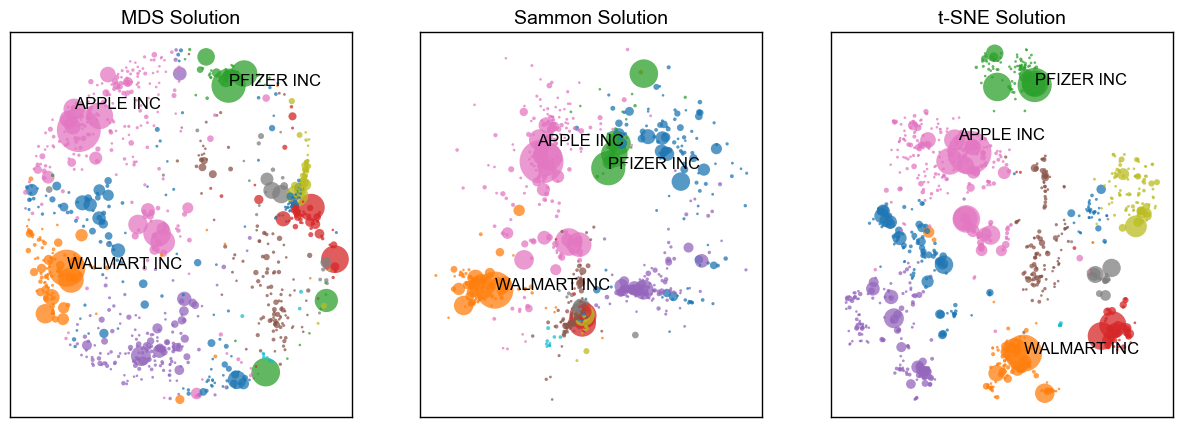

In [19]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (15, 5))

draw_map(
    Y_MDS, 
    color = clusters,
    label = labels,
    show_axes = False, 
    highlighted_labels=['APPLE INC', 'WALMART INC', 'PFIZER INC'], 
    size = market_caps, 
    ax = ax[0], 
    scatter_kws={'edgecolors':'none'})
ax[0].set_title('MDS Solution', fontsize = 14)

draw_map(
    Y_sammon, 
    label = labels, 
    show_axes = False, 
    highlighted_labels= ['APPLE INC', 'WALMART INC', 'PFIZER INC'],
    color = clusters,  
    size = market_caps, 
    ax = ax[1],
    scatter_kws={'edgecolors':'none'})
ax[1].set_title('Sammon Solution', fontsize = 14)

draw_map(
    Y_tsne, 
    label = labels,
    show_axes = False, 
    highlighted_labels=['APPLE INC', 'WALMART INC', 'PFIZER INC'],
    color = clusters, 
    size = market_caps, 
    ax = ax[2],
    scatter_kws={'edgecolors':'none'})

ax[2].set_title('t-SNE Solution', fontsize = 14)

fig